# Calculation of polarons

Author: J. Lafuente-Bartolome' (v1, XX/01/2024) <br>
Revision: F. Giustino (v1.1, 07/23/2024) <br>
Revision: S. Tiwari (v1.2, 09/30/2024) <br>


In this notebook, we perform calculations of polarons. The theory and computational method are described in [Phys. Rev. Lett. **122**, 246403 (2019)](https://doi.org/10.1103/PhysRevLett.122.246403) and [Phys. Rev. B **99**, 235139 (2019)](https://doi.org/10.1103/PhysRevB.99.235139). 

Electrons and phonons are computed with Quantum ESPRESSO (QE), maximally-localized Wannier functions are computed with Wannier90, and polarons are computed with EPW. 

## Theory

Here, we briefly present the main concepts and equations that are solved by EPW to obtain polaron formation energy, wavefunction, and atomic displacements.

The ground state wave function $\psi(\mathbf{r})$ and atomic displacements $\Delta \tau_{\kappa\alpha p}$ of the polarons are found by minimizing the total energy functional
of an excess electron added to a crystal. This minimization problem translates into the solution of the following coupled system of equations:
$$
  \hat{H}_{\mathrm{KS}}^{0} \, \psi(\mathbf{r})
  +
  \sum_{\kappa\alpha p} \frac{\partial V_{\mathrm{KS}}^{0}}{\partial \tau_{\kappa \alpha p}}
  \Delta \tau_{\kappa \alpha p} \, \psi(\mathbf{r})
  =
  \varepsilon \, \psi(\mathbf{r}) ~,
$$
$$
  \Delta \tau_{\kappa \alpha p}
  =
  -\sum_{\kappa'\alpha' p'} (C^{0})^{-1}_{\kappa\alpha p,\kappa'\alpha'p'}
  \int d\mathbf{r} \, \frac{\partial V_{\mathrm{KS}}^{0}}{\partial \tau_{\kappa'\alpha'p'}}
  \, |\psi(\mathbf{r})|^2 ~.
$$
In these expressions, $\tau_{\kappa\alpha p}$ represents the Cartesian coordinate
of atom $\kappa$ in unit cell $p$ along the direction $\alpha$, $C^{0}_{\kappa\alpha p,\kappa'\alpha'p'}$ is the matrix of interatomic force constants, and $\hat{H}_{\mathrm{KS}}^{0}$ and $V_{\mathrm{KS}}^{0}$ represent the Kohn-Sham Hamiltonian and the self-consistent potential, respectively. The superscript $^{0}$ indicates that these quantities are evaluated in the ground state without extra electron. The integral is performed over a Born-Von Karman supercell of the crystal containing $N_p$ unit cells. We will refer to $\varepsilon$ as the polaron eigenvalue.

By expanding the polaron wave function in terms of the single-particle Kohn-Sham states 
$\psi_{n\mathbf{k}}$ with eigenvalues $\varepsilon_{n\mathbf{k}}$:
$$
  \psi(\mathbf{r}) = \frac{1}{\sqrt{N_p}}
  \sum_{n\mathbf{k}} A_{n\mathbf{k}} \psi_{n\mathbf{k}} ~,
$$
and the atomic displacements in terms of the phonon eigenmodes $e_{\kappa\alpha,\nu}(\mathbf{q})$ with frequencies $\omega_{\mathbf{q}\nu}$:
$$
  \Delta\tau_{\kappa\alpha p } = -\frac{2}{N_p}
  \sum_{\mathbf{q}\nu} B^{*}_{\mathbf{q}\nu} 
  \left( \frac{\hbar}{2M_\kappa \omega_{\mathbf{q}\nu}} \right)^{1/2}
  e_{\kappa\alpha,\nu}(\mathbf{q}) \, e^{i\mathbf{q}\cdot\mathbf{R}_p},
$$
where $M_\kappa$ is the mass of the atom $\kappa$ and $\mathbf{R}_p$ is the lattice vector of the unit cell $p$, we can transform the first two equations into a coupled set of equations for the expansion coefficients in reciprocal space:
$$
  \frac{2}{N_p} \sum_{\mathbf{q}m\nu} B_{\mathbf{q}\nu}
  \, g_{mn\nu}^{*}(\mathbf{k},\mathbf{q}) \, A_{m\mathbf{k+q}}
  =
  (\varepsilon_{n\mathbf{k}}-\varepsilon) A_{n\mathbf{k}} ~,
$$
$$
  B_{\mathbf{q}\nu} = \frac{1}{N_p}
  \sum_{mn\mathbf{k}} A^{*}_{m\mathbf{k+q}}
  \frac{g_{mn\nu}(\mathbf{k},\mathbf{q})}{\hbar\omega_{\mathbf{q}\nu}} A_{n\mathbf{k}} ~.
$$
The polaron formation energy $\Delta E_{f}$, defined as the energy required to trap 
a conduction band state with eigenvalue $\varepsilon_{\mathrm{CBM}}$ into a localized polaron, can be obtained from  the expansion coefficients that solve the coupled set of equations by:
$$
  \label{eq:eq3}
  \Delta E_{f}
  =
  \frac{1}{N_p} \sum_{n\mathbf{k}} |A_{n\mathbf{k}}|^2
  (\varepsilon_{n\mathbf{k}}-\varepsilon_{\mathrm{CBM}})
  -
  -    \frac{1}{N_p} \sum_{\mathbf{q}\nu} |B_{\mathbf{q}\nu}|^2 \hbar\omega_{\mathbf{q}\nu} ~.
$$
We will refer to the first and second terms on the right hand side as the electron and phonon parts of the formation energy, respectively.

From these expressions, we observe that
the necessary ingredients to solve the polaron equations
are the Kohn-Sham eigenvalues,
phonon frequencies,
and electron-phonon matrix elements on the $\mathbf{k}$- and $\mathbf{q}$-grids
corresponding to the equivalent Born-Von Karman supercell 
in which the first two equations are defined.
In order to obtain the formation energy of an isolated polaron,
we will need to solve the coupled set of equations in increasingly denser grids
and extrapolate the results to the infinite supercell limit.

## Set up working environment

Load required modules:

In [1]:
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MultipleLocator,FormatStrFormatter
import os
from EPWpy import EPWpy
from EPWpy.plotting import plot_wannier
from EPWpy.plotting import plot_polaron
from EPWpy.utilities import EPW_util

Set paths to relevant directories:

In [2]:
# Set prefix
prefix='lif'

Set the number of cores to be used in the calculations:

In [3]:
# Maximum number of cores to be used
cores = 4
print('Maximum number of cores to be used:', cores)

Maximum number of cores to be used: 4


Define general calculation parameters to be used throughout the workflow:

In [4]:
lif=EPWpy.EPWpy({'prefix':'\''+prefix+'\'',
           'restart_mode':'\'from_scratch\'',
           'calculation':'\'scf\'',
           'ibrav':2,
           'nat':2,
           'ntyp':2,
           'atomic_species':['Li', 'F'],
           'atomic_pos':np.array([[0.0, 0.0, 0.0], [-0.5, 0.5, 0.5]]), # in alat
           'mass':[6.941, 18.9984],
           'atoms':['Li', 'F'],
           'ecutwfc':'80',
           'celldm(1)':'7.67034',
           'verbosity':'\'high\'',
           'pseudo_auto':True},
           env='mpirun',
           system='lif')
lif.run_serial = True
lif.env = 'mpirun'
#'pseudo_dir':'\''+str(pseudo)+'\''},

# Print relevant info
os.system('module list')


                                                                                                                         
                                                                                          
                                       -*#*-                             ...............- 
                          .+*=      .+%*-=%%:      .=#*-               -===============-:.
                        :*%=*%%-    *%*   #%*    :+%+-%%+             .:.  -=.   :==-.    
                        -%S  -%%*: :#%.   -%%-. -##:  #%*                  -=.   :==-     
                ..      .%S:   +%%%%*.     :*%%%#=    %%=                  -=.   :==-     
              :=#%%*-   .#S-     ..                  .%%=     :*#*:        -=.   :==-     
             -%S:.=#%%*==%#                           *%%=::=##-+%%.  .   .=-.   :==-  .= 
             :%%-   .-+++:                             -+##*=.  =%S   :-::==:    .==-  --.
              *%#                                         

sh: 1: module: not found


32512

## Workflow

We will consider a hole polaron in LiF as an example.

### Preliminary scf, ph, and nscf calculations

In [5]:
# Prepare scf input file
lif.scf(electrons={'conv_thr':'1.0d-12'}, kpoints={'kpoints':[[6, 6, 6]]}, name='scf')
lif.prepare(type_run='scf')

# Run scf calculation
lif.run(4)

-- -- -- -- -- -- -- -- -- -- --  Calculation: scf  -- -- -- -- -- -- -- -- -- -- -- 
Running scf |████████████████████████████████████████| in 2.9s (0.64/s)         

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


In [7]:
# Prepare ph input file
lif.ph(phonons={'nq1':3,
                'nq2':3,
                'nq3':3})

# Run ph calculation
lif.prepare(type_run='ph')
lif.run(4,type_run='ph')

-- -- -- -- -- -- -- -- -- -- --  Calculation: ph  -- -- -- -- -- -- -- -- -- -- -- 
Running ph |████████████████████████████████████████| in 1:22.7 (0.02/s)        

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


In [8]:
# Prepare nscf input file
lif.nscf(system={'nbnd':15},kpoints={'grid':[6, 6, 6],'kpoints_type': 'crystal'})
lif.prepare(type_run='nscf')
# Run nscf calculation
lif.run(4,type_run='nscf')

-- -- -- -- -- -- -- -- -- -- --  Calculation: nscf  -- -- -- -- -- -- -- -- -- -- -- 
Running nscf |████████████████████████████████████████| in 12.5s (0.11/s)       

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


### Coarse mesh epw calculations

In [11]:
# Prepare epw input for coarse mesh calculation
lif.reset()
lif.epw(epwin={'proj':['\'F : p\''],
               'wannier_plot':'.true.',
               'band_plot':'.true.',
               'filkf':'\'./path.kpt\'',
               'filqf':'\'./path.kpt\'',
               'num_iter':500,
               'epbwrite':'.false.',
               'nbndsub':'3',
               'bands_skipped':'\'exclude_bands = 1:2, 6:15\'',
               'wannier_plot':'.true.',
               'wannier_plot_supercell':'6, 6, 6',
               'lpolar':'.true.',
               'eig_read':'.false.',
              'wannierize':'.true.'},
        name='epw1')
# Generate filkf if needed

W=[0.5,0.75,0.25]
L=[0.0,0.5,0.0]
G=[0.0,0.0,0.0]
X=[0.5,0.5,0.0]
K=[0.375,0.75,0.375]
sympoints=[W,L,G,X,W,K]
#
lif.filkf(path=sympoints, length=[41, 41, 41, 41, 41], name='path.kpt')

#
lif.prepare(type_run='epw1') 

obtaining nscf and ph attributes
-- -- -- -- -- -- -- -- -- -- -- -- -- Info -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Based on previous pw and ph calculations some parameters are set below
lpolar:  .true. (related to epsil in ph)
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
(4, 3)
[51, 51, 51]


In [12]:
print(lif.code)

#lif.env='mpirun -np 4'
lif.run(4,type_run='epw1')

/mnt/storage/sabya/For_video/epwpy/build/q-e-EPW-5.9s/bin
-- -- -- -- -- -- -- -- -- -- --  Calculation: epw1  -- -- -- -- -- -- -- -- -- -- -- 
Running epw1 |████████████████████████████████████████| in 48.9s (0.03/s)       

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


### Wannier function plots

Notebook initialized with png backend.
Positive isosurface contour set to: 0.76612 (10% of max value: 7.6612)



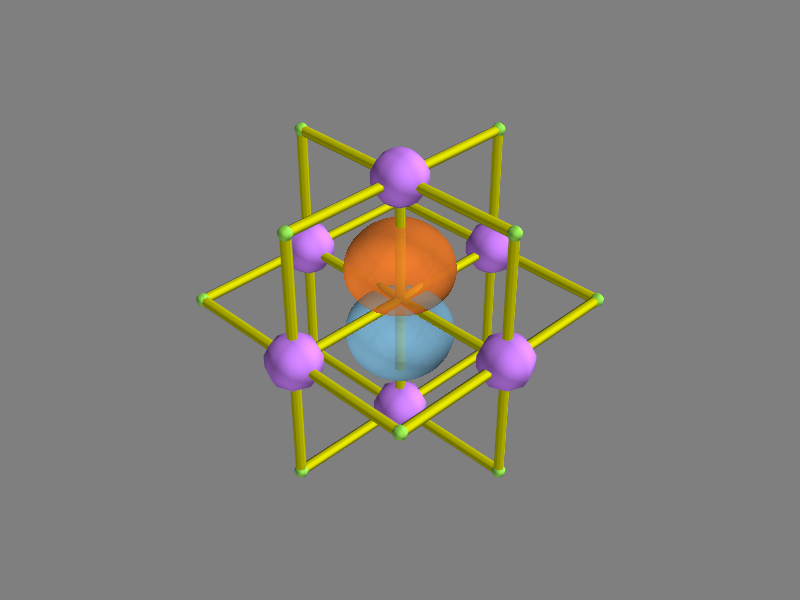

In [8]:
# Specify the path to your .cube file
cube_file = f'{lif.prefix}/epw/lif_00001.cube'
# Read .cube file
Data = EPW_util.read_cube_file(cube_file, 4.0) #Cube file and bonds
Data['in_notebook']=True   # Telling the plotter that you want to see in notebook mode
Data['backend']='png'   # Backend can be png or ipy (which gives an interactive widget)
Data['verbosity'] = 1 # Telling if extra stuff needs to be printed (set to > 2 for printing)
# Plot the isosurface and atomic positions
L = plot_wannier.plot_isosurface_from_cube_file(Data)
L

### Interpolation to fine mesh and solution of polaron equations

In [12]:
# Prepare epw input for fine mesh interpolation and polaron calculation
lif.epw(epwin={'bands_skipped':'\'exclude_bands = 1:2, 6:15\'',
               'nbndsub':3,
               'plrn':'.true.',
               'restart_plrn':'.false.',
               'type_plrn':1,
               'init_plrn':1,
               'init_sigma_plrn':1.0,
               'niter_plrn':500,
               'conv_thr_plrn':1.0E-4,
               'ethrdg_plrn':1.0E-6,
               'adapt_ethrdg_plrn':'.true.',
               'init_ethrdg_plrn':1.0E-4,
               'nethrdg_plrn':20,
               'io_lvl_plrn':0,
               'nkf1':6,
               'nkf2':6,
               'nkf3':6,
               'nqf1':6,
               'nqf2':6,
               'nqf3':6,
               'lpolar':'.true.',
               'eig_read':'.false.'},
            name='epw2')

#
lif.prepare(1,type_run='epw2')

obtaining nscf and ph attributes
-- -- -- -- -- -- -- -- -- -- -- -- -- Warning -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Refreshing EPW input (remove refresh from epw_save.json if not needed)
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- -- -- -- Info -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Based on previous pw and ph calculations some parameters are set below
lpolar:  .true. (related to epsil in ph)
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


In [13]:
# Run
lif.run(4,type_run='epw2')

-- -- -- -- -- -- -- -- -- -- --  Calculation: epw2  -- -- -- -- -- -- -- -- -- -- -- 
Running epw2 |████████████████████████████████████████| in 5.7s (0.27/s)        

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


## Visualization and post-processing

In [14]:
# Prepare epw input for postprocessing calculation
lif.epw(epwin={'bands_skipped':'\'exclude_bands = 1:2, 6:15\'',
               'plrn':'.true.',
               'restart_plrn':'.true.',
               'type_plrn':1,
               'cal_psir_plrn':'.true.',
               'step_wf_grid_plrn':4,
               'interp_Ank_plrn':'.true.',
               'interp_Bqu_plrn':'.true.',
               'filkf':'\'../path.kpt\'',
               'filqf':'\'../path.kpt\'',
               'nkf1':6,
               'nkf2':6,
               'nkf3':6,
               'nqf1':6,
               'nqf2':6,
               'nqf3':6,
               'eig_read':'.false.',
               'lpolar':'.true.'},
            name='epw3')
lif.prepare(1,type_run='epw3')

-- -- -- -- -- -- -- -- -- -- -- -- -- Warning -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Refreshing EPW input (remove refresh from epw_save.json if not needed)
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- -- -- -- Info -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Based on previous pw and ph calculations some parameters are set below
lpolar:  .true. (related to epsil in ph)
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


cp: cannot stat '../path.kpt': No such file or directory


In [15]:
# Run post-processing
lif.run(4,type_run='epw3')

-- -- -- -- -- -- -- -- -- -- --  Calculation: epw3  -- -- -- -- -- -- -- -- -- -- -- 
Running epw3 |████████████████████████████████████████| in 4.9s (0.32/s)        

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


### Plot polaron wave function

Using EPWpy we can visualize polarons, where arrows show the displacements and the isosurface shows the polaron wave function. Below we plot the hole polaron wavefunction in LiF (Li in red and F in blue).

['-12.1769074', '0.0000000', '12.1769074']
['0.0000000', '12.1769074', '12.1769074']
['-12.1769074', '12.1769074', '0.0000000']
432
Notebook initialized with png backend.



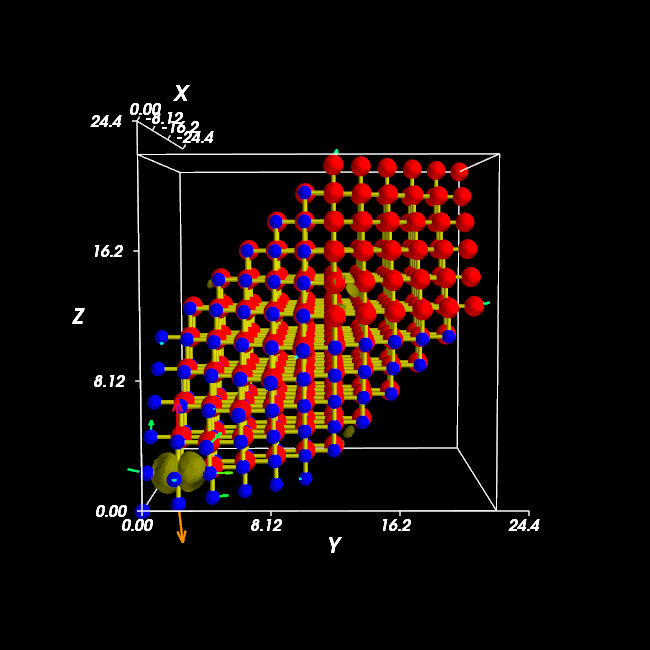

In [18]:
# Plot polaron wavefunction in real space
Data=EPW_util.read_psir_plrn(f'./{lif.prefix}/epw/psir_plrn.xsf')
Data['in_notebook']=True   # Telling the plotter that you want to see in notebook mode
Data['backend']='png'   # Backend can be png or ipy (which gives an interactive widget)
plot_polaron.plot_psir_plrn(Data)

### Plot expansion coefficients

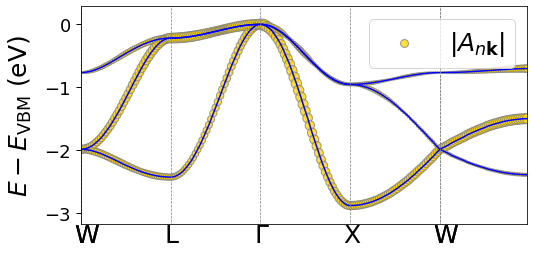

In [21]:
# Plot Ank coefficients
W=[0.5,0.75,0.25]
L=[0.0,0.5,0.0]
G=[0.0,0.0,0.0]
X=[0.5,0.5,0.0]
K=[0.375,0.75,0.375]
sympoints=[W,L,G,X,W,K]
plot_polaron.plot_Ank_Bqv('Ank', prefix+'/epw/path.kpt', sympoints, prefix+'/epw/Ank.band.plrn')

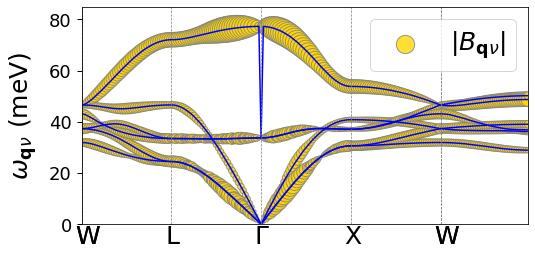

In [22]:
# Plot Bqv coefficients
plot_polaron.plot_Ank_Bqv('Bqv', prefix+'/path.kpt', sympoints, prefix+'/epw/Bmat.band.plrn')

## Extrapolation to the isolated polaron limit ($N_p\rightarrow\infty$)

In [23]:
# List of k-point meshes to consider
klist = [8, 10, 12]

for k in klist:
    lif.epw(epwin={'bands_skipped':'\'exclude_bands = 1:2, 6:15\'',
               'plrn':'.true.',
               'restart_plrn':'.false.',
               'type_plrn':1,
               'init_plrn':1,
               'init_sigma_plrn':1.0,
               'niter_plrn':500,
               'conv_thr_plrn':1.0E-4,
               'ethrdg_plrn':1.0E-6,
               'adapt_ethrdg_plrn':'.true.',
               'init_ethrdg_plrn':1.0E-4,
               'nethrdg_plrn':20,
               'io_lvl_plrn':0,
               'lpolar':'.true.',
               'nkf1':str(k),
               'nkf2':str(k),
               'nkf3':str(k),
               'nqf1':str(k),
               'nqf2':str(k),
               'nqf3':str(k),
               'eig_read':'.false.'},
            name='epw4.'+str(k))

#
    lif.prepare(1,type_run='epw3',name = 'epw',infile='epw4.'+str(k)+'.in')

-- -- -- -- -- -- -- -- -- -- -- -- -- Warning -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Refreshing EPW input (remove refresh from epw_save.json if not needed)
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- -- -- -- Info -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Based on previous pw and ph calculations some parameters are set below
lpolar:  .true. (related to epsil in ph)
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- -- -- -- Warning -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Refreshing EPW input (remove refresh from epw_save.json if not needed)
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- -- -- -- Info -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Based on previous pw and ph calculations some parameters are set below
lpolar:  .true. (related to epsil in ph)
-- -- -

cp: cannot stat '../path.kpt': No such file or directory
cp: cannot stat '../path.kpt': No such file or directory
cp: cannot stat '../path.kpt': No such file or directory


In [24]:
# Run calculations
lif.run_serial=True
for k in klist:
    lif.run(16, type_run='epw3', infile='epw4.'+str(k))

-- -- -- -- -- -- -- -- -- -- --  Calculation: epw4.8  -- -- -- -- -- -- -- -- -- -- -- 
Running epw4.8 |████████████████████████████████████████| in 8.1s (0.18/s)      

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- --  Calculation: epw4.10  -- -- -- -- -- -- -- -- -- -- -- 
Running epw4.10 |████████████████████████████████████████| in 22.8s (0.06/s)    

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- --  Calculation: epw4.12  -- -- -- -- -- -- -- -- -- -- -- 
Running epw4.12 |████████████████████████████████████████| in 1:09.7 (0.02/s)   

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


Extrapolation to isolated polaron formation energy =  -2.989 eV


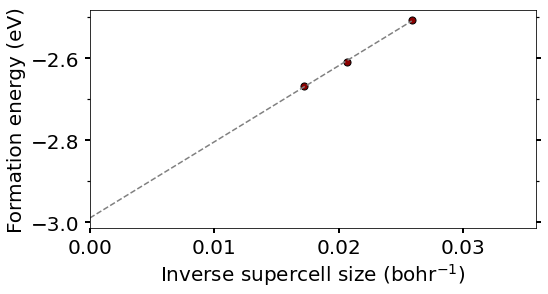

In [25]:
## Linear fit and extrapolate to Np->\infty

# Set unit cell volume in Bohr^3 (to convert Nk to inverse supercell size)
ucell_volume = 112.8044

# Read formation energies from output files
Eform = []
for k in klist:
    lif.epw_file = 'epw4.'+str(k)
    Eform.append(lif.Eform)

Nk = np.array(klist)
Eform = np.array(Eform)
                    
# Plot
plot_polaron.plot_EvsNk(ucell_volume, Nk, Eform)